In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


plt.style.use('ggplot')

# Introduction

The problem statement for this dataset is to build a machine learning model that can accurately predict whether a patient has diabetes based on their gender and medical history.
The features in the dataset are:

* gender: This is a categorical feature that can be either "Male" or "Female".
* age: This is a numerical feature that represents the patient's age in years.
* hypertension: This is a categorical feature that can be either "0" (no hypertension) or "1" (hypertension).
* heart_disease: This is a categorical feature that can be either "0" (no heart disease) or "1" (heart disease).
* smoking_history: This is a categorical feature that can be "never", "ever", or "current smoker".
* bmi: This is a numerical feature that represents the patient's body mass index.
* HbA1c_level: This is a numerical feature that represents the patient's HbA1c level, which is a measure of blood sugar control over the past 3 months.
* blood_glucose_level: This is a numerical feature that represents the patient's blood glucose level at the time of the test.
* diabetes: This is the target variable that the model will predict. It is a categorical feature that can be either "0" (no diabetes) or "1" (diabetes).

In [ ]:
data = pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


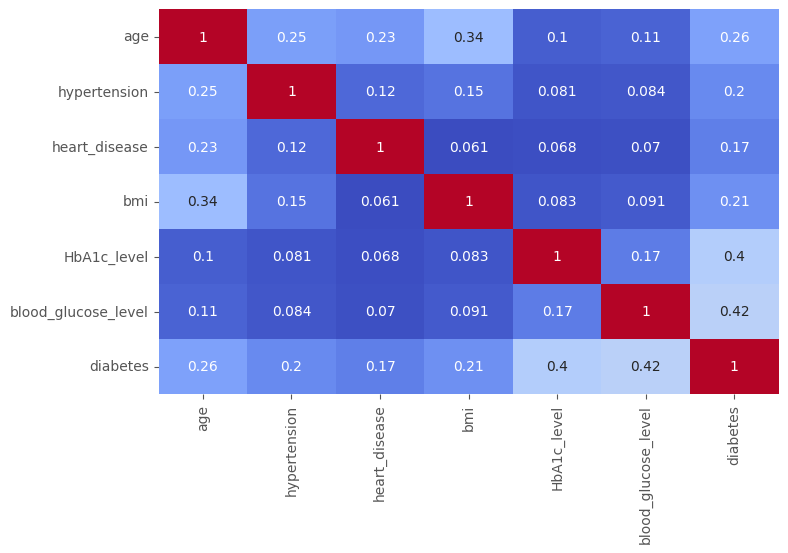

In [ ]:
num_cols = [col for col in data.columns if data[col].dtype != 'O']
plt.figure(figsize=(8,5))
sns.heatmap(data[num_cols].corr(),cmap='coolwarm',annot=True,cbar=False)
plt.show()

In [ ]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

It looks like we have a clean dataset – no missing values to handle! Additionally, the lack of strong feature correlations tells us we might need to employ some feature engineering techniques. But first, let's perform some EDA to investigate any potential outliers.

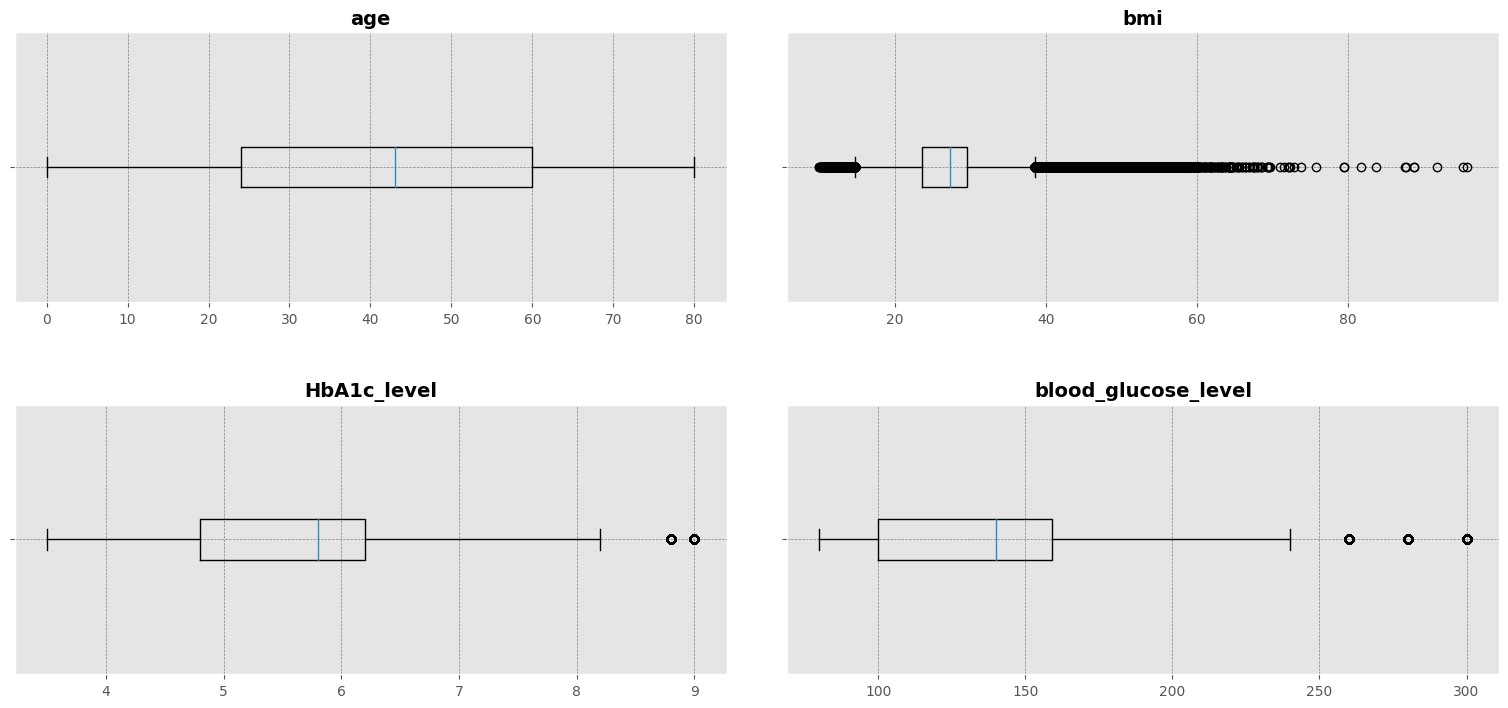

In [ ]:
num_cols = [col for col in data.columns[:-1] if (data[col].dtype != 'O') & (col not in ['hypertension','heart_disease'])]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ax = ax.flatten()
boxplot_color = 'steelblue'
for i, col in enumerate(num_cols):
    bp = ax[i].boxplot(data[col], vert=False)
    ax[i].set_title(col, fontsize=14, fontweight='bold')
    ax[i].grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
    ax[i].set_yticklabels([])
plt.tight_layout(pad=4.0)
plt.show()


As we can see there are some interesting patterns. Age seems evenly distributed, with a wide range for the middle portion of our participants, likely between ages 20 and 60.  also we don't see any extreme age outliers. BMI, on the other hand, is skewed to the right, indicating a few individuals with very high BMIs. Most participants have similar BMIs, but those outliers on the right warrant further investigation. HbA1c levels appear mostly centered around a normal range, with a slight tail to the right suggesting some individuals have higher levels.  Finally, blood glucose levels show a lot of variability with a few potential outliers at the higher end, suggesting some participants may have significantly elevated blood sugar.Let's take a closer look at BMI

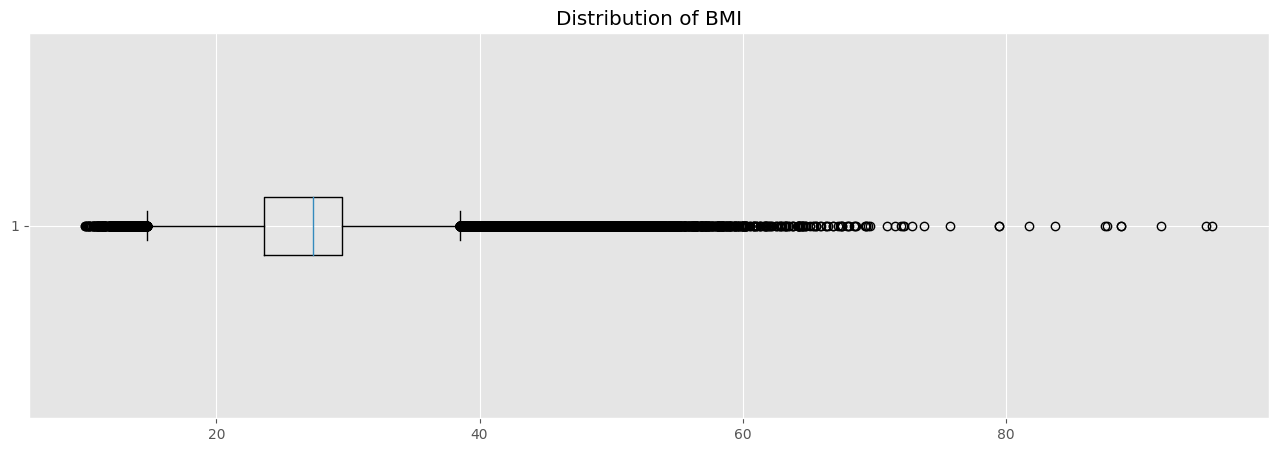

In [ ]:
plt.figure(figsize=(16,5))
plt.boxplot(data['bmi'],vert=False)
plt.title("Distribution of BMI")
plt.show()

Okay, we've definitely got some outliers to consider. It's important to remember that not all unusual data points are automatically bad – they could just mean our data doesn't follow a perfectly normal distribution. Some algorithms are designed to handle that! For now, let's hold off on modifying the outliers and see if they contribute something interesting to our results.

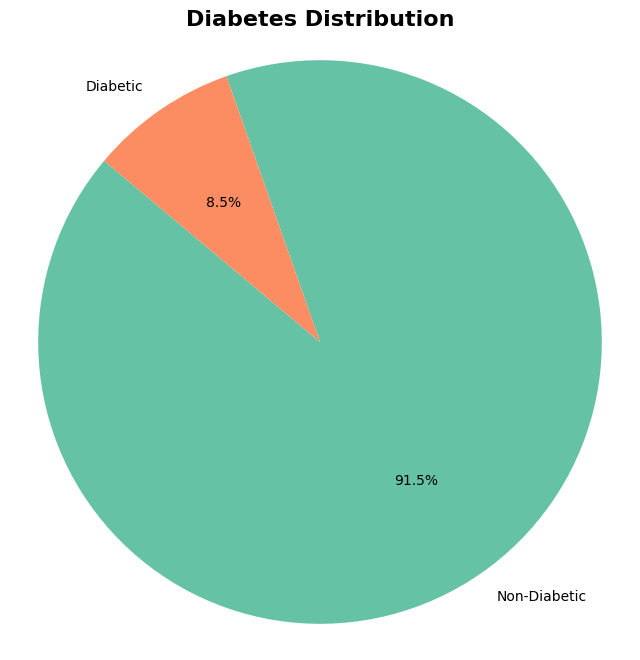

In [ ]:
diabetes_counts = data['diabetes'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(diabetes_counts, labels=['Non-Diabetic','Diabetic'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Diabetes Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()


So we are dealing with an imbalanced target variable, while Decision trees, random forests, and gradient boosting can be good starting points. However, if we are still needing better results, we might have to try some specialized techniques that can help other algorithms excel even with imbalanced datasets.

# Feature engineering

## Age Groups

Categorizing age into groups (like 18-30, 31-50, etc.) is a good strategy in these cases. This is because diabetes risk and related factors can change significantly across different age ranges. By grouping ages, our model has a better chance of identifying those age-specific patterns, potentially improving its accuracy.

In [ ]:
data['age_groups'] = pd.cut(data['age'],bins = [0,12,19,29,39,54,64,float('inf')],labels = ['child','teenager','young adult','adult','midle aged','old','senior']).astype('O')

## BMI Groups

Another useful step for your diabetes classification model is to categorize the 'bmi' column. We can group individuals into underweight, normal weight, overweight, and obese categories based on established medical standards from the World Health Organization (WHO).  Here's a helpful reference for these classifications: https://en.wikipedia.org/wiki/Body_mass_index#Categories.

This categorization is important because BMI is a strong indicator of health risks, including diabetes. By grouping individuals based on their BMI, our model can better identify patterns between weight and the likelihood of diabetes.


In [ ]:
data['bmi_groups'] = pd.cut(data['bmi'],bins = [0,18.4,24.9,29.9,float('inf')],labels = ['under weight','normal','overweight','obese']).astype('O')

Classifying Blood_glucose_level and HbA1c_level could be valuable for your diabetes classification model. However, the ambiguity around whether the blood glucose measurements are fasting or non-fasting is a concern. This lack of clarity could make interactions with other variables less reliable, potentially impacting your model's accuracy.

## Interaction Features

Creating new features by combining existing ones can potentially reveal hidden patterns and give our machine learning model a performance boost.  Let's look at the interaction features we create:

* **Hypertension and Heart Disease:** A binary feature highlighting the presence of both conditions makes sense, as these often  indicate heightened diabetes risk.
* **Age and Hypertension/Heart Disease:** The impact of hypertension and heart disease does shift with age, so creating features that combine age with these conditions could help your model pinpoint those nuances.
* **BMI and Blood Glucose Level:**  Since both factors are strongly linked to diabetes, exploring their combined effect could be very insightful.


In [ ]:
data['HH'] = ((data['hypertension'] == 1) & (data['heart_disease'] == 1)).astype(int)
data['AH'] = data['age'] * data['hypertension']
data['AHD'] = data['age'] * data['heart_disease']
data['BB'] = data['blood_glucose_level'] * data['bmi']

Finally, let's encode our remaining categorical variables

In [ ]:
data['gender'] = np.where(data['gender'].str.lower() == 'female', 0, 1)
data = pd.get_dummies(data=data,columns=['smoking_history','age_groups','bmi_groups'],drop_first=True,dtype=int)
data.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,HH,AH,...,smoking_history_not current,age_groups_child,age_groups_midle aged,age_groups_old,age_groups_senior,age_groups_teenager,age_groups_young adult,bmi_groups_obese,bmi_groups_overweight,bmi_groups_under weight
0,0,80.0,0,1,25.19,6.6,140,0,0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,0,54.0,0,0,27.32,6.6,80,0,0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,1,28.0,0,0,27.32,5.7,158,0,0,0.0,...,0,0,0,0,0,0,1,0,1,0
3,0,36.0,0,0,23.45,5.0,155,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,76.0,1,1,20.14,4.8,155,0,1,76.0,...,0,0,0,0,1,0,0,0,0,0


# Model

In [ ]:
def plot_cm(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    tick_marks = [0.5, 1.5]
    class_names = ['Negative', 'Positive']
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names, rotation=0)
    plt.show()

def print_metrics(model,X_train,X_test,y_train,y_test):
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    print(f"Test Accuracy Score : {accuracy_score(y_train,y_pred_train):.4f}")
    print(f"Test Accuracy Score : {accuracy_score(y_test,y_pred):.4f}")
    plot_cm(y_test,y_pred)

def fit_model(model,X,y,standardize = True):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 1)
    if standardize:
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    model.fit(X_train,y_train)
    print_metrics(model,X_train,X_test,y_train,y_test)
    return model


In [ ]:
X = data.drop(['diabetes'],axis=1).values
y = data['diabetes'].values

## Logistic Regression

Test Accuracy Score : 0.8872
Test Accuracy Score : 0.8874


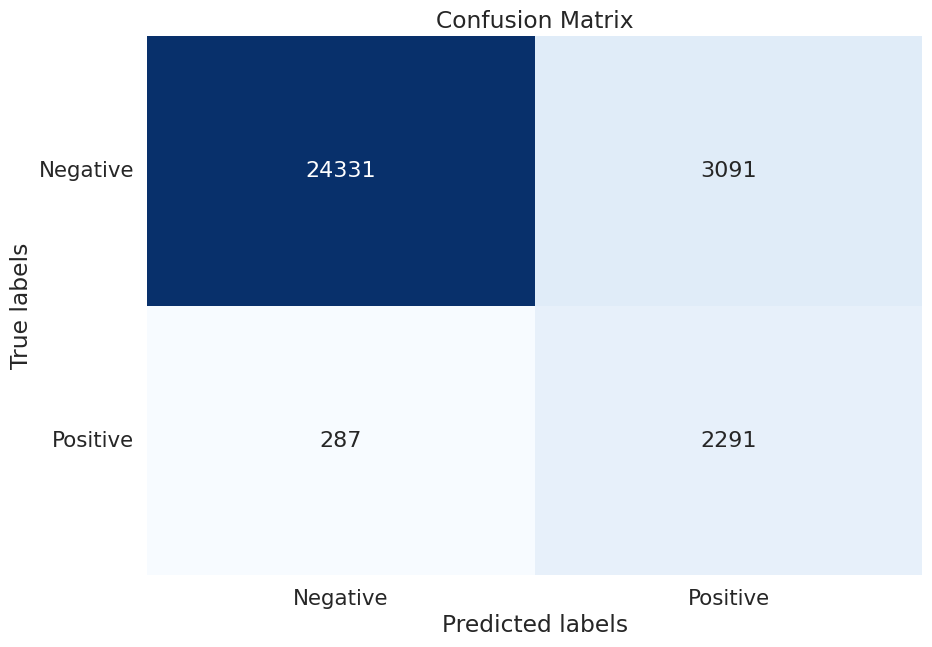

In [ ]:
lg_reg = LogisticRegression(class_weight='balanced')
lg_reg = fit_model(lg_reg,X,y)

## Support Vector Machines (Linear)

Test Accuracy Score : 0.9637
Test Accuracy Score : 0.9615


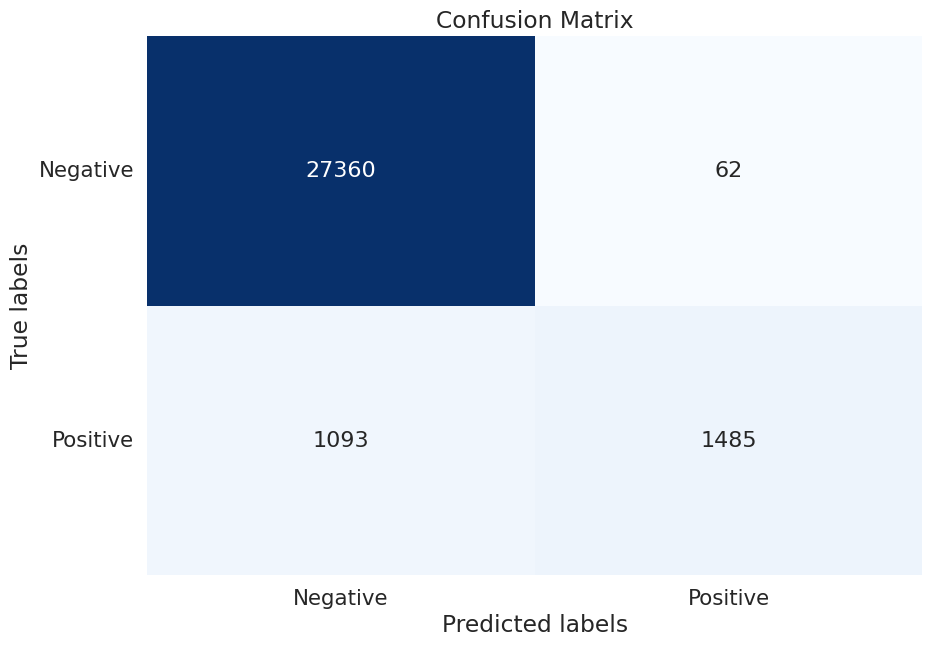

In [ ]:
sv = SVC()
sv = fit_model(sv,X,y)

## Support Vector Machines (RBF)

Test Accuracy Score : 0.8865
Test Accuracy Score : 0.8868


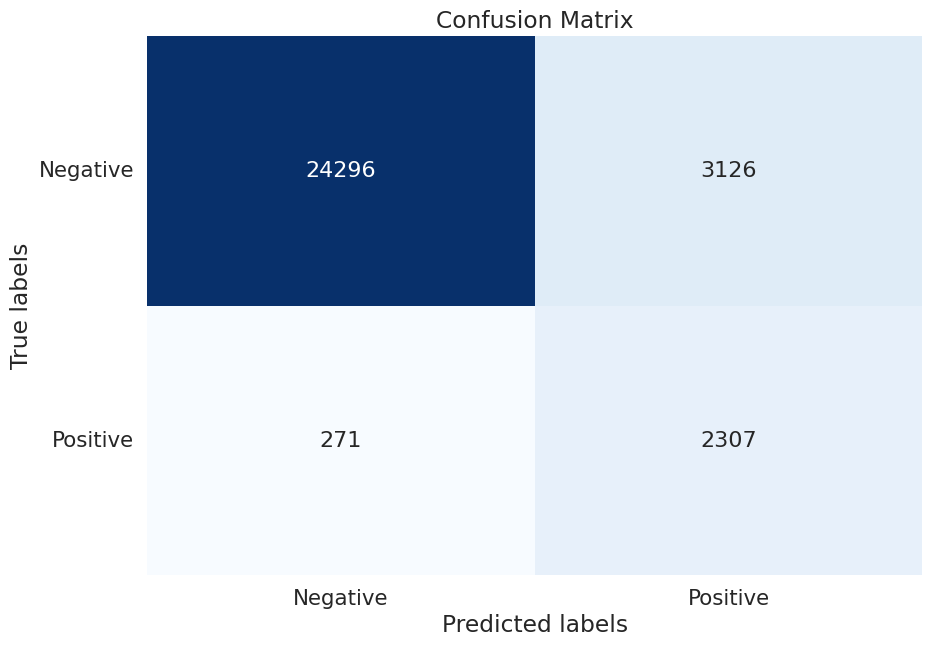

In [ ]:
sv = SVC(kernel='rbf',gamma=0.001,C = 20,class_weight='balanced')
sv = fit_model(sv,X,y)

## Decision Trees

Test Accuracy Score : 0.9723
Test Accuracy Score : 0.9710


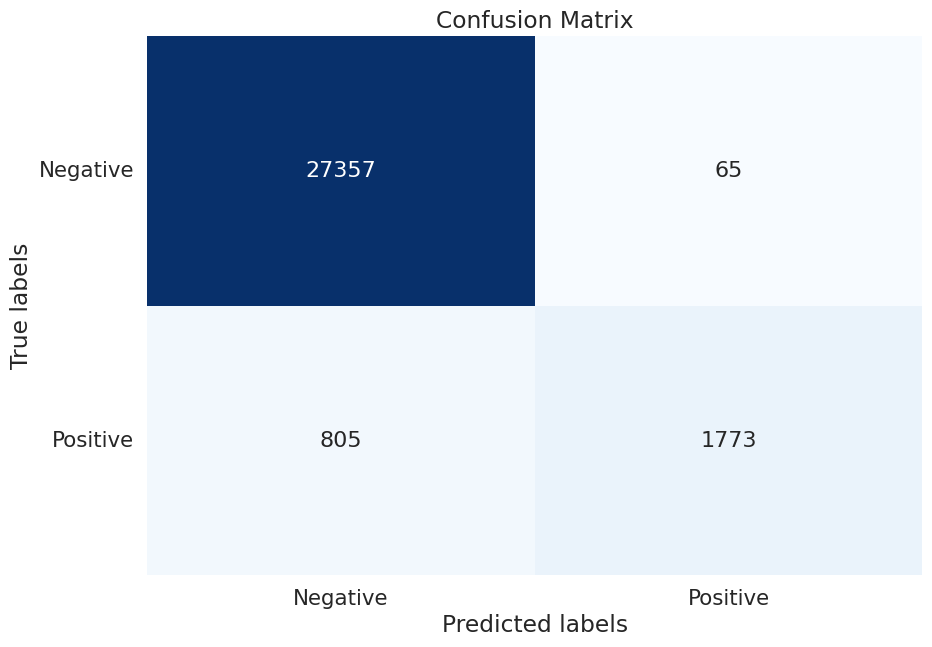

In [ ]:
dt = DecisionTreeClassifier(max_depth = 10,random_state = 1,criterion='entropy')
dt = fit_model(dt,X,y)

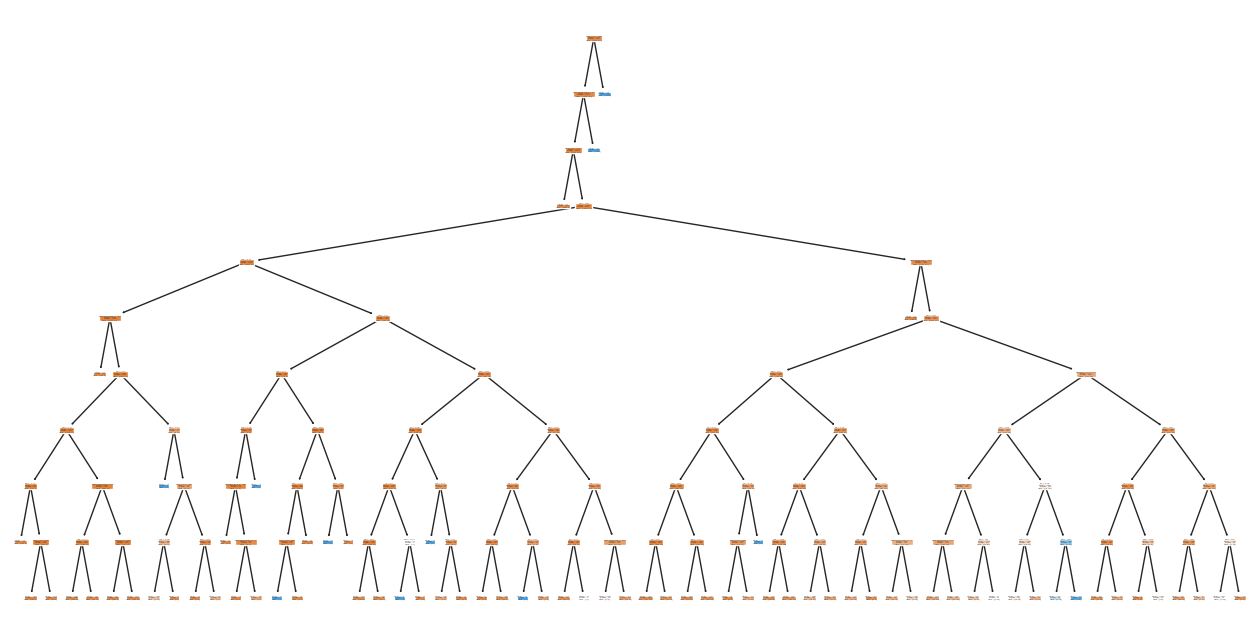

In [ ]:
plt.figure(figsize=(16,8))
feature_names = data.columns[:-1]
tree.plot_tree(dt,feature_names = feature_names,filled=True)
plt.show()

## Random Forest

Test Accuracy Score : 0.9773
Test Accuracy Score : 0.9721


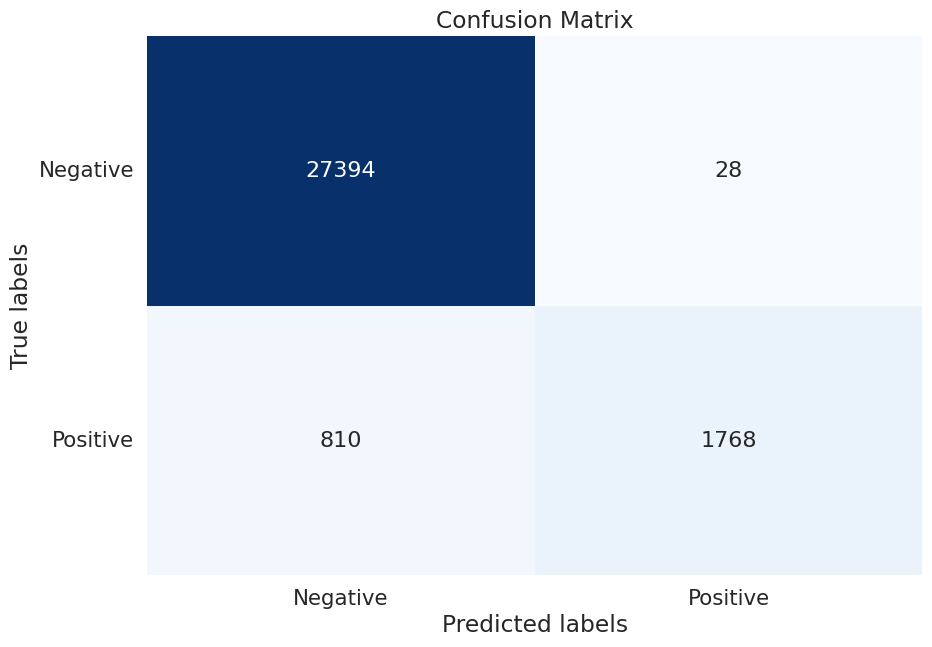

In [ ]:
rf = RandomForestClassifier(n_estimators=50,random_state=1,max_depth=15)
rf = fit_model(rf,X,y)

## K nearest neighbours

Test Accuracy Score : 0.9654
Test Accuracy Score : 0.9543


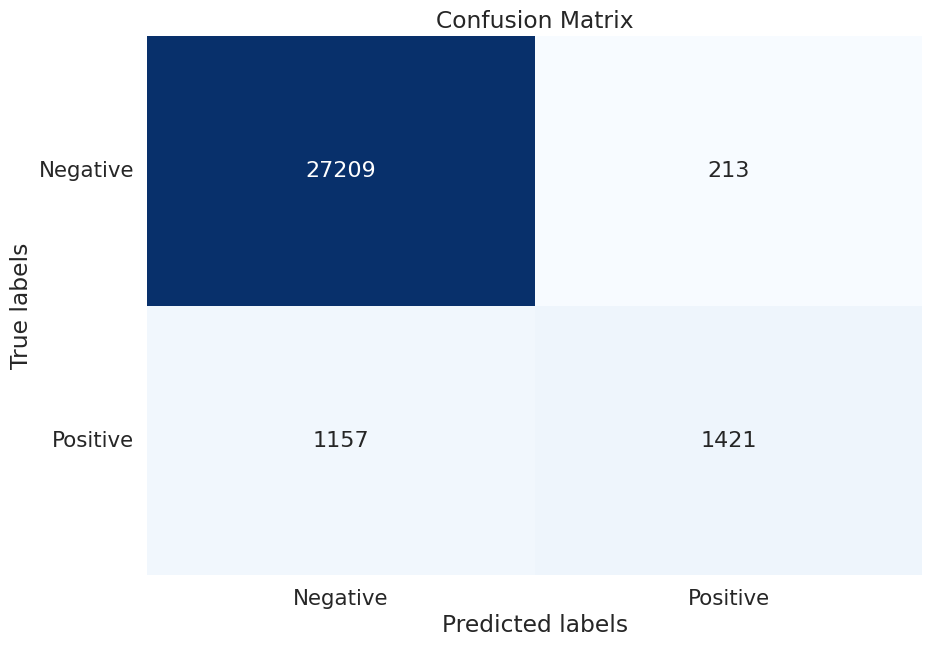

In [ ]:
kn = KNeighborsClassifier(n_neighbors=5)
kn = fit_model(kn,X,y)

# Neural Networks

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)


train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [ ]:
X_train.shape[1]

25

In [ ]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer1 = nn.Linear(25, 128)
        self.layer2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.2)
        self.layer3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

In [ ]:
model = BinaryClassificationModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
for epoch in range(epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.1471
Epoch [2/10], Loss: 0.1111
Epoch [3/10], Loss: 0.0811
Epoch [4/10], Loss: 0.1811
Epoch [5/10], Loss: 0.0579
Epoch [6/10], Loss: 0.0231
Epoch [7/10], Loss: 0.2480
Epoch [8/10], Loss: 0.1641
Epoch [9/10], Loss: 0.1272
Epoch [10/10], Loss: 0.0597


Training Accuracy: 0.9716
Test Accuracy: 0.9706


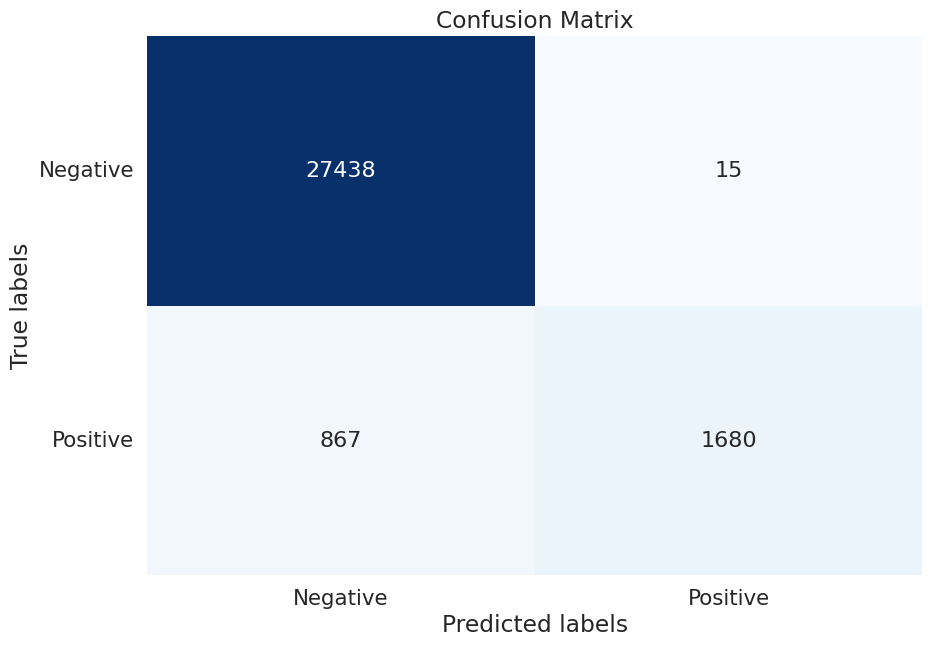

In [ ]:
with torch.no_grad():
    y_pred_train = model(X_train_tensor).round()
    y_pred_test = model(X_test_tensor).round()

train_acc = accuracy_score(y_train_tensor, y_pred_train)
test_acc = accuracy_score(y_test_tensor, y_pred_test)
cm = confusion_matrix(y_test_tensor, y_pred_test)

print(f'Training Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
plot_cm(y_test_tensor,y_pred_test)

We can also modify class weights addressing class imbalance

In [ ]:
positive_weight = len(y_train) / (2 * np.sum(y_train == 1))
negative_weight = len(y_train) / (2 * np.sum(y_train == 0))
class_weights = torch.tensor([negative_weight, positive_weight], dtype=torch.float)

model = BinaryClassificationModel()
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
for epoch in range(epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.9139
Epoch [2/10], Loss: 0.9234
Epoch [3/10], Loss: 0.9004
Epoch [4/10], Loss: 0.8489
Epoch [5/10], Loss: 1.1791
Epoch [6/10], Loss: 0.8870
Epoch [7/10], Loss: 0.9722
Epoch [8/10], Loss: 0.9543
Epoch [9/10], Loss: 0.8121
Epoch [10/10], Loss: 0.9211


Training Accuracy: 0.9493
Test Accuracy: 0.9487


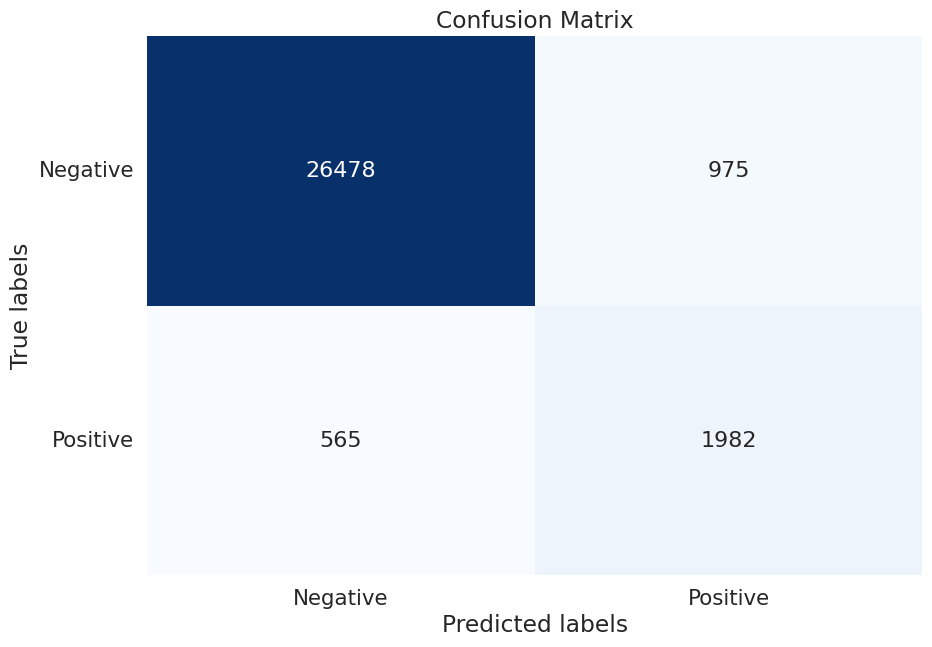

In [ ]:
with torch.no_grad():
    y_pred_train = model(X_train_tensor).round()
    y_pred_test = model(X_test_tensor).round()

train_acc = accuracy_score(y_train_tensor, y_pred_train)
test_acc = accuracy_score(y_test_tensor, y_pred_test)
cm = confusion_matrix(y_test_tensor, y_pred_test)

print(f'Training Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
plot_cm(y_test_tensor,y_pred_test)

**Understanding Model Results**


**High-Performing Models**

* **Decision Trees & Random Forest:** These model surprised us a bit, slightly outperforming the linear SVM. Its accuracy and low false positives/negatives hint at strong pattern recognition within the data.
* **Neural Networks:**  The strong agreement between training and test accuracy indicates good generalization – meaning the model can effectively classify unseen diabetes cases.  

**Conservative vs. Balanced Models**

* **SVC (linear kernel) & KNN:** These models prioritize minimizing false positives (incorrect diabetes diagnoses). This is valuable if misdiagnoses are particularly harmful, but we have to consider the trade-off with potentially more false negatives (missed diagnoses).
* **Logistic Regression & SVC (RBF kernel):**  These models seek a  balance between false positive and false negatives. While their overall accuracy may be slightly lower, they might be preferable if both types of errors are  undesirable.

**Conclusion**

It's essential to remember that the right model for our project depends on its specific goals.  

* **Prioritizing Missed Diagnoses:** If minimizing false negatives is paramount, the Random Forest model could be a strong contender.
* **Prioritizing Incorrect Diagnoses:** When minimizing false positives is most critical, the SVC with a linear kernel might be more suitable.